In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist
import matplotlib.patches as mpatches
import os
from matplotlib.colors import ListedColormap
from plotly.colors import sample_colorscale


EW 20251210: next block likely outdated but useful for plotting settings

In [11]:


# === Define your 10 categorical colors (your custom palette) ===
colors_hex_cat = [
    '#fbe6c5', '#f7c9a7', '#f3aa91', '#ee8a82', '#e2797a',
    '#d56973', '#c8586c', '#ab4762', '#8d3757', '#70284a'
]
cmap_cat = colors_hex_cat

# === Assign MR method colors from this new palette ===
method_colors = {
    'Inverse variance weighted': cmap_cat[9],  # "#70284a" darkest
    'Weighted median': cmap_cat[6],            # "#c8586c"
    'MR Egger': cmap_cat[2],                    # "#f3aa91"
}

# === Legend handles with these colors ===
legend_handles = [
    mpatches.Patch(color=method_colors['Inverse variance weighted'], label='Inverse variance weighted'),
    mpatches.Patch(color=method_colors['Weighted median'], label='Weighted median'),
    mpatches.Patch(color=method_colors['MR Egger'], label='MR Egger'),
]

fontsize_ticks = 14
fontsize_labels = 14
cap_length = 0.05

# EW new 20251124
font='Arial'

# === Load and prepare Panel A data ===
df_a = pd.read_excel("/MR/TwoSampleMR/forward-MR-BAG-updated.xlsx")
for col in ['b', 'se', 'pval']:
    df_a[col] = df_a[col].astype(str).str.replace(',', '.', regex=False).astype(float)
df_a['ci_lower'] = df_a['b'] - 1.96 * df_a['se']
df_a['ci_upper'] = df_a['b'] + 1.96 * df_a['se']
df_a['outcome'] = df_a['outcome'].str.capitalize()
df_a['method'] = df_a['method'].str.strip()  # clean whitespace

exposures_a = df_a['exposure'].unique()[::-1]
exposure_positions_a = {exposure: i for i, exposure in enumerate(exposures_a)}
method_offset = {'Inverse variance weighted': -0.25, 'Weighted median': 0, 'MR Egger': 0.25}
df_a['y'] = df_a.apply(lambda row: exposure_positions_a[row['exposure']] + method_offset[row['method']], axis=1)

# === Load and prepare Panel B data ===
df_b = pd.read_excel("/MR/TwoSampleMR/reverse-MR-BAG-updated.xlsx")
for col in ['b', 'se', 'pval']:
    df_b[col] = df_b[col].astype(str).str.replace(',', '.', regex=False).astype(float)
df_b['ci_lower'] = df_b['b'] - 1.96 * df_b['se']
df_b['ci_upper'] = df_b['b'] + 1.96 * df_b['se']
df_b['method'] = df_b['method'].str.strip()  # clean whitespace

exposures_b = df_b['outcome'].unique()[::-1]
exposure_positions_b = {exposure: i for i, exposure in enumerate(exposures_b)}
df_b['y'] = df_b.apply(lambda row: exposure_positions_b[row['outcome']] + method_offset[row['method']], axis=1)

# === Create subplots ===
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10), sharex=False)

# Disable all grid lines
ax1.grid(False)
ax2.grid(False)

# --- Panel A ---
x_min_a, x_max_a = -0.35, 0.30
clip_buffer_a = 0.02
x_min_buf_a = x_min_a + clip_buffer_a
x_max_buf_a = x_max_a - clip_buffer_a
arrow_gap_a = 0.01

for _, row in df_a.iterrows():
    y = row['y']
    color = method_colors.get(row['method'], '#aaaaaa')
    ci_l, ci_u = row['ci_lower'], row['ci_upper']
    clipped_l = max(ci_l, x_min_buf_a)
    clipped_u = min(ci_u, x_max_buf_a)
    is_clip_l = ci_l < x_min_buf_a
    is_clip_r = ci_u > x_max_buf_a
    ci_start = clipped_l + arrow_gap_a if is_clip_l else clipped_l
    ci_end = clipped_u - arrow_gap_a if is_clip_r else clipped_u

    ax1.plot(row['b'], y, 'o', color=color, markersize=10, markeredgewidth=1.5, markeredgecolor='white')
    ax1.plot([ci_start, ci_end], [y, y], color=color, linewidth=2)
    if not is_clip_l:
        ax1.plot([clipped_l, clipped_l], [y - cap_length, y + cap_length], color=color, linewidth=1.5)
    else:
        ax1.annotate('', xy=(x_min_buf_a, y), xytext=(x_min_buf_a + 0.015, y),
                     arrowprops=dict(arrowstyle='-|>', color=color, lw=2))
    if not is_clip_r:
        ax1.plot([clipped_u, clipped_u], [y - cap_length, y + cap_length], color=color, linewidth=1.5)
    else:
        ax1.annotate('', xy=(x_max_buf_a, y), xytext=(x_max_buf_a - 0.015, y),
                     arrowprops=dict(arrowstyle='-|>', color=color, lw=2))

ax1.axvline(0, color='gray', linestyle='--')
ax1.set_yticks(range(len(exposures_a)))
ax1.set_yticklabels(exposures_a, fontsize=fontsize_ticks)
ax1.set_xlim(x_min_a, x_max_a)
ax1.set_xlabel("Beta (95% CI)", fontsize=fontsize_labels)
ax1.set_title("A", loc='left', fontsize=16, weight='bold')
#ax1.grid(axis='x', linestyle='--', color='gray', alpha=0.15)
ax1.invert_yaxis()

# --- Panel B ---
x_min_b, x_max_b = -6, 6
clip_buffer_b = 0.1
x_min_buf_b = x_min_b + clip_buffer_b
x_max_buf_b = x_max_b - clip_buffer_b
arrow_gap_b = 0.3

for _, row in df_b.iterrows():
    y = row['y']
    color = method_colors.get(row['method'], '#aaaaaa')
    ci_l, ci_u = row['ci_lower'], row['ci_upper']
    clipped_l = max(ci_l, x_min_buf_b)
    clipped_u = min(ci_u, x_max_buf_b)
    is_clip_l = ci_l < x_min_buf_b
    is_clip_r = ci_u > x_max_buf_b
    ci_start = clipped_l + arrow_gap_b if is_clip_l else clipped_l
    ci_end = clipped_u - arrow_gap_b if is_clip_r else clipped_u

    ax2.plot(row['b'], y, 'o', color=color, markersize=10, markeredgewidth=1.5, markeredgecolor='white')
    ax2.plot([ci_start, ci_end], [y, y], color=color, linewidth=2)
    if not is_clip_l:
        ax2.plot([clipped_l, clipped_l], [y - cap_length, y + cap_length], color=color, linewidth=1.5)
    else:
        ax2.annotate('', xy=(x_min_buf_b, y), xytext=(x_min_buf_b + 0.015, y),
                     arrowprops=dict(arrowstyle='-|>', color=color, lw=2))
    if not is_clip_r:
        ax2.plot([clipped_u, clipped_u], [y - cap_length, y + cap_length], color=color, linewidth=1.5)
    else:
        ax2.annotate('', xy=(x_max_buf_b, y), xytext=(x_max_buf_b - 0.015, y),
                     arrowprops=dict(arrowstyle='-|>', color=color, lw=2))

ax2.axvline(0, color='gray', linestyle='--')
ax2.set_yticks(range(len(exposures_b)))
ax2.set_yticklabels(exposures_b, fontsize=fontsize_ticks)
ax2.set_xlim(x_min_b, x_max_b)
ax2.set_xlabel("Beta (95% CI)", fontsize=fontsize_labels)
ax2.set_title("B", loc='left', fontsize=16, weight='bold')
#ax2.grid(axis='x', linestyle='--', color='gray', alpha=0.15)
ax2.invert_yaxis()
ax1.grid(axis='y', visible=False)

# === Shared legend below panels ===
fig.legend(handles=legend_handles, title="MR Method", fontsize=fontsize_ticks,
           loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0.04, 1, 1])  # leave space for legend
#plt.savefig("MR/mr_panels_A_B_custom_palette.png", dpi=300, bbox_inches='tight')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/MR/TwoSampleMR/forward-MR-BAG-updated.xlsx'

## genetic correlation heatmap plot between datasets

EW 20251210: next block likely outdated but useful for plotting settings

     BAGHan  BAGLeonardsen  BAGJawinski    BAGWen  BAGKaufmann  BAGSmith
0  1.000000       0.369667     0.395101  0.551517     0.754649  0.459957
1  0.369667       1.000000     0.814565  0.686337     0.532754  0.656653
2  0.395101       0.814565     1.000000  0.699002     0.574350  0.641514
3  0.551517       0.686337     0.699002  1.000000     0.699867  0.927106
4  0.754649       0.532754     0.574350  0.699867     1.000000  0.743915
                             BAG$_{\mathrm{Wen}}$  BAG$_{\mathrm{Han}}$  \
BAG$_{\mathrm{Han}}$                     0.551517              1.000000   
BAG$_{\mathrm{Smith}}$                   0.927106              0.459957   
BAG$_{\mathrm{Jawinski}}$                0.699002              0.395101   
BAG$_{\mathrm{Leonardsen}}$              0.686337              0.369667   
BAG$_{\mathrm{Kaufmann}}$                0.699867              0.754649   

                             BAG$_{\mathrm{Smith}}$  \
BAG$_{\mathrm{Han}}$                       0.459957   
B

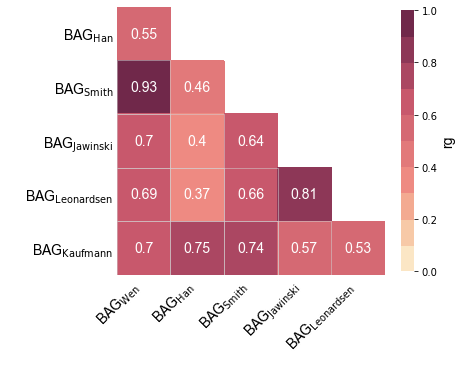

In [33]:
#  df2 = pd.read_csv(cwd + "/gCorr_BA/gCorr.csv", delimiter='\t', index_col=0)

df2 = pd.read_csv(cwd + "/gCorr_BA/gCorr-gsem-updated.csv")
print(df2.head())

# Set the index to the column names, making the DataFrame symmetric with proper row and col labels
df2.index = df2.columns

def add_subscript(label, subscript_part):
    return f"BAG$_{{\\mathrm{{{subscript_part}}}}}$"


# Example: transform columns like "BAGWen" to "BAG_{Wen}"
new_labels = []
for name in df2.columns:
    # Extract the part after 'BAG' for subscript, assuming consistent format
    if name.startswith("BAG"):
        sub = name[3:]  # "Wen" from "BAGWen"
        new_label = add_subscript("BAG", sub)
    else:
        new_label = name
    new_labels.append(new_label)

# Assign new labels
df2.columns = new_labels
df2.index = new_labels  # if you want rows renamed similarly


# Ensure symmetry
#df2 = (df2 + df2.T) / 2

# Clustering
dist = pdist(df2.values, metric='euclidean')
link = linkage(dist, method='average')

# EW new 20251124
#order = leaves_list(link)
order = [3, 0, 5, 2, 1, 4]


df_clustered = df2.iloc[order, order]

# === Mask upper triangle ===
mask = np.triu(np.ones_like(df_clustered, dtype=bool))

# Remove fully masked rows (top) and columns (right) to eliminate white space
valid_rows = ~mask.all(axis=1)
valid_cols = ~mask.all(axis=0)

df_trimmed = df_clustered.loc[valid_rows, valid_cols]
mask_trimmed = mask[valid_rows][:, valid_cols]

print(df_trimmed.head())

# === Plot ===
plt.figure(figsize=(6, 6))
#ax = sns.heatmap(
#    df_trimmed,
#    annot=True,
#    cmap=cmap_cat,
#    mask=mask_trimmed,
#    square=True,
#    vmin=0,
#    vmax=1, 
#    annot_kws={"size": fontsize_ticks, "fontname": font}
#)

ax = sns.heatmap(
    df_trimmed,
    annot=True,
    cmap=cmap_cat,
    mask=mask_trimmed,
    square=True,
    vmin=0,
    vmax=1,
    annot_kws={"size": fontsize_ticks, "fontname": font},
    xticklabels=True,
    yticklabels=True,
    linewidth=0,  # no borders by seaborn
)

# Add faint borders to lower triangle only
import matplotlib.patches as patches
n = df_trimmed.shape[0]
for i in range(n):
    for j in range(n):
        if i > j:
            rect = patches.Rectangle((j, i), 1, 1, fill=False, edgecolor='lightgray', linewidth=0.5)
            ax.add_patch(rect)

ax.grid(False)

# Tick labels
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha='right',
    fontsize=fontsize_ticks,
    fontname=font
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    fontsize=fontsize_ticks,
    fontname=font
)

# EW new 20251124: Remove tick marks
ax.tick_params(
    axis='x',       # x-axis
    length=0        # set tick length to 0
)
ax.tick_params(
    axis='y',       # y-axis
    length=0
)

# Labels and title
ax.set_xlabel(" ", fontsize=fontsize_labels, fontname=font)
ax.set_ylabel(" ", fontsize=fontsize_labels, fontname=font)
#ax.set_title("Genetic Correlation Heatmap", fontsize=fontsize_title, fontname=font, weight='bold') # can change title here

# Colorbar
cbar = ax.collections[0].colorbar
#cbar.ax.tick_params(labelsize=fontsize_ticks_bar)
pos = cbar.ax.get_position()
new_height = pos.height *0.8 # bigger or smaller color bar length
new_bottom = pos.y0 + (pos.height - new_height) / 2
cbar.ax.set_position([pos.x0, new_bottom, pos.width, new_height])
cbar.set_label("rg", fontsize=fontsize_labels, fontname=font)

#plt.savefig("gCorr_BA/genetic_correlation_plot_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()




## Adding FDR correction to genetic correlations

EW 20251210: next block likely outdated but useful for plotting settings

In [139]:
import os
import pandas as pd
from statsmodels.stats.multitest import fdrcorrection

# Load data
cwd = os.getcwd()
file_path = os.path.join(cwd, 'LDSC/results.tsv')
df = pd.read_csv(file_path, sep='\t')

# Apply standard BH-FDR correction (Benjamini-Hochberg)
rejected, pvals_corrected = fdrcorrection(df['Pvalue'], alpha=0.05, method='indep')

# Add results to DataFrame
df['FDR_BH'] = pvals_corrected
df['Significant_FDR_05'] = rejected

# Optional: sort by GeneticCorrelation
df = df.sort_values("GeneticCorrelation")

# Save to new .tsv
output_path = os.path.join(cwd, 'LDSC/results_with_fdr.tsv')
df.to_csv(output_path, sep='\t', index=False)


## Genetic correlation plot with traits

EW 20251210: next block likely outdated but useful for plotting settings

                        Trait  GeneticCorrelation      SE  Zscore    Pvalue  \
0   longevity_90th_percentile             -0.2790  0.0859 -3.2481  0.001200   
1                   wen-renal              0.0014  0.0419  0.0340  0.972900   
2                    PAI1_EUR              0.0036  0.1708  0.0211  0.983200   
3                         cad              0.0069  0.0559  0.1241  0.901200   
4                          pp              0.0105  0.0289  0.3628  0.716800   
5          wen-cardiovascular              0.0135  0.0445  0.3040  0.761100   
6          resting-heart-rate              0.0190  0.0254  0.7455  0.456000   
7                    IEAA_EUR              0.0264  0.0698  0.3788  0.704800   
8                         ASD              0.0269  0.0575  0.4670  0.640500   
9                  loneliness              0.0292  0.0407  0.7162  0.473800   
10             sleep-duration              0.0407  0.0340  1.1979  0.230900   
11          MDD2018_ex23andMe              0.0431  0

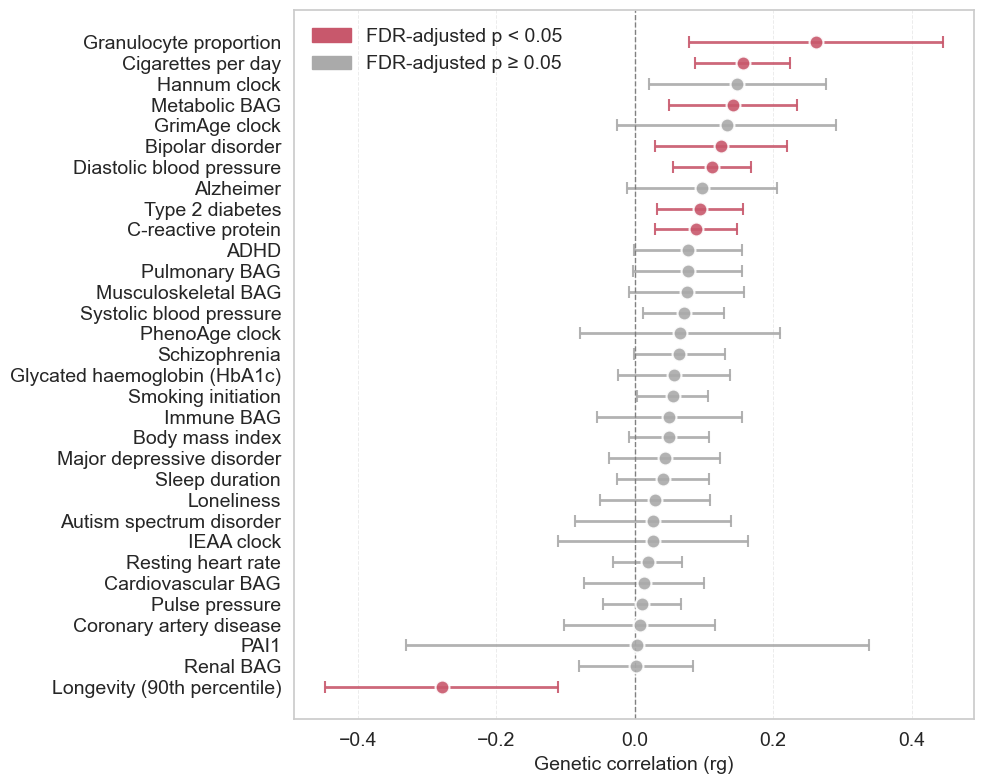

In [140]:
file_path = cwd+'/LDSC/results_with_fdr.tsv'
df = pd.read_csv(file_path, sep='\t')
#df = df.sort_values("GeneticCorrelation")
print(df)

#fontsize_labels = 16
#fontsize_ticks = 16

plt.figure(figsize=(10, 8))

y_pos = range(len(df))

# colours: significant in red, nonsig in light gray
sig_color = cmap_cat[6] # pick color from 0 to 9
nonsig_color = '#aaaaaa'  # light gray

custom_labels = [
    "Longevity (90th percentile)",
    "Renal BAG",
    "PAI1",
    "Coronary artery disease",
    "Pulse pressure",
    "Cardiovascular BAG",
    "Resting heart rate",
    "IEAA clock",
    "Autism spectrum disorder",
    "Loneliness",
    "Sleep duration",
    "Major depressive disorder",
    "Body mass index",
    "Immune BAG",
    "Smoking initiation",
    "Glycated haemoglobin (HbA1c)",
    "Schizophrenia",
    "PhenoAge clock",
    "Systolic blood pressure",
    "Musculoskeletal BAG",
    "Pulmonary BAG",
    "ADHD",
    "C-reactive protein",
    "Type 2 diabetes",
    "Alzheimer",
    "Diastolic blood pressure",
    "Bipolar disorder",
    "GrimAge clock",
    "Metabolic BAG",
    "Hannum clock",
    "Cigarettes per day",
    "Granulocyte proportion"
]


df['plot_labels'] = custom_labels

for i, (gc, se, pval, fdr_sig) in enumerate(zip(df["GeneticCorrelation"], df["SE"], df["Pvalue"], df['Significant_FDR_05'])):
    color = sig_color if fdr_sig else nonsig_color
    ci95 = 1.96 * se 
    
    # plot the circle with error bar
    plt.errorbar(gc, i, xerr=ci95, fmt='o', color=color,
                 ecolor=color, elinewidth=2, capsize=4,
                 markersize=10, markeredgewidth=1.5,
                 markeredgecolor='white', alpha=0.9)



# Apply updated labels to y-axis
plt.yticks(y_pos, df['plot_labels'], fontsize=fontsize_ticks)
plt.xticks(fontsize=fontsize_ticks)
plt.xlabel("Genetic correlation (rg)", fontsize=fontsize_labels)
#plt.title("Genetic Correlations of Brain Age with Other Traits", fontsize=fontsize_title, weight='bold')
plt.axvline(0, color='gray', linestyle='--', linewidth=1) #vertical line on the 0

# show only vertical grid lines, subtle and light
plt.grid(axis='x', linestyle='--', color='gray', alpha=0.15, linewidth=0.7)
plt.grid(axis='y', visible=False)  # hide horizontal grid lines

sig_patch = mpatches.Patch(color=sig_color, label='FDR-adjusted p < 0.05')
nonsig_patch = mpatches.Patch(color=nonsig_color, label='FDR-adjusted p ≥ 0.05')

plt.legend(
    handles=[sig_patch, nonsig_patch],
    fontsize=fontsize_ticks,
    frameon=False,
    loc='upper left'
)


#plt.gca().set_facecolor('#f9f9f9')

plt.tight_layout()

# Save the plot to a file
plt.savefig('LDSC/genetic_correlation_fdr.png', dpi=300, bbox_inches='tight')

plt.show()


## MR plot

In [101]:
EW 20251210: next block likely outdated but useful for plotting settings

SyntaxError: invalid syntax (<ipython-input-101-9b07fe08e925>, line 1)

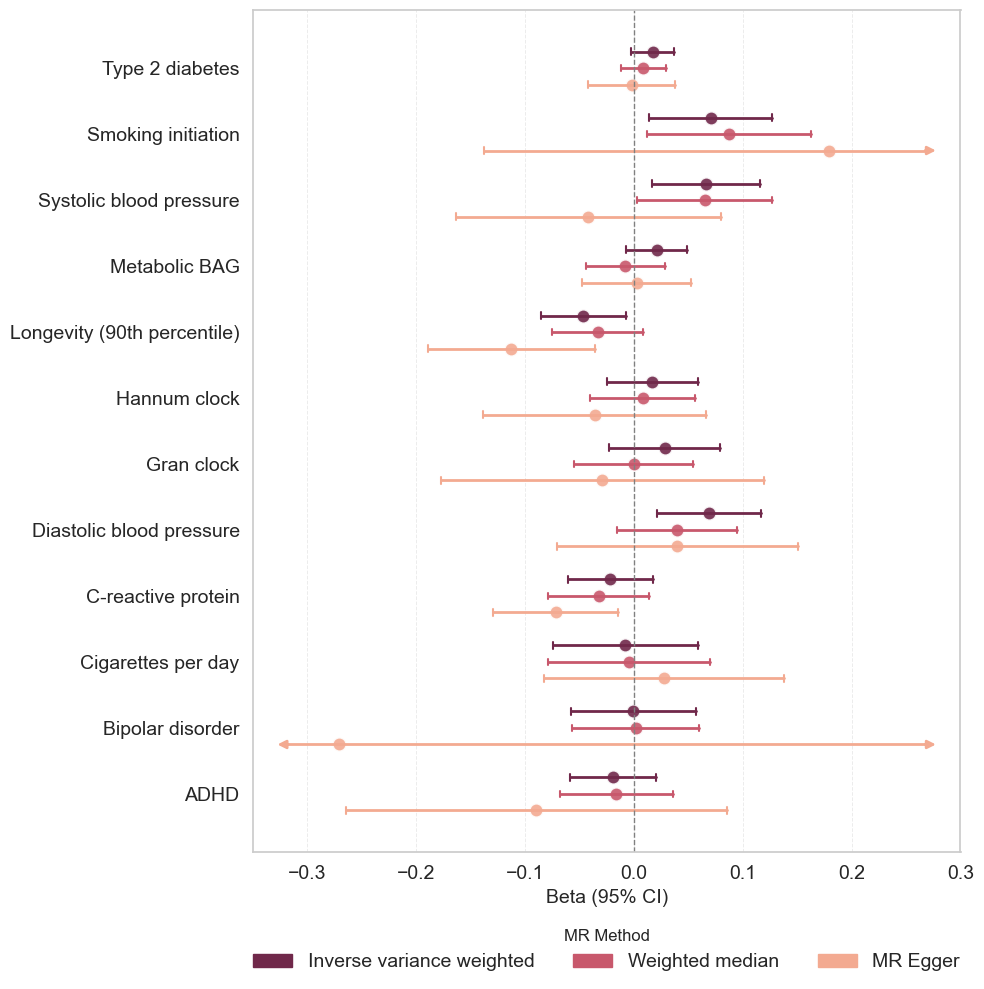

In [89]:
# ==== load data ====
#df = pd.read_excel(cwd+"/MR/TwoSampleMR/combined-output/combined-results-FDR-by-method.xlsx")
df = pd.read_excel("MR/TwoSampleMR/forward-MR-BAG-updated.xlsx")

# ==== convert columns ====
for col in ['b', 'se', 'pval']:
    df[col] = df[col].astype(str).str.replace(',', '.', regex=False).astype(float)

df['ci_lower'] = df['b'] - 1.96 * df['se']
df['ci_upper'] = df['b'] + 1.96 * df['se']
df['outcome'] = df['outcome'].str.capitalize()

# ==== plot settings ====
exposures = df['exposure'].unique()[::-1]

methods = ['Inverse variance weighted', 'Weighted median', 'MR Egger']
method_colors = {
    'Inverse variance weighted': cmap_cat[9],  
    'Weighted median': cmap_cat[6],            
    'MR Egger': cmap_cat[2]                     
}

exposure_positions = {exposure: i for i, exposure in enumerate(exposures)}
method_offset = {'Inverse variance weighted': -0.25,
                 'Weighted median': 0,
                 'MR Egger': 0.25}
df['y'] = df.apply(lambda row: exposure_positions[row['exposure']] + method_offset[row['method']], axis=1)

# ==== clip Settings ====
x_min, x_max = -0.35, 0.30
clip_buffer = 0.02
x_min_buffered = x_min + clip_buffer
x_max_buffered = x_max - clip_buffer
arrow_gap = 0.01  # how far before the arrow to end the CI line
cap_length = 0.05

fontsize_ticks = 14
fontsize_labels = 14

# ==== plot ====
plt.figure(figsize=(10,10))

for _, row in df.iterrows():
    if row['b'] < x_min or row['b'] > x_max:
        continue

    y = row['y']
    color = method_colors.get(row['method'], '#aaaaaa')  # fallback to light gray

    # real and clipped CIs
    ci_lower, ci_upper = row['ci_lower'], row['ci_upper']
    clipped_lower = max(ci_lower, x_min_buffered)
    clipped_upper = min(ci_upper, x_max_buffered)

    # determine if clipped
    is_clipped_left = ci_lower < x_min_buffered
    is_clipped_right = ci_upper > x_max_buffered

    # adjust line ends to avoid overlapping with arrow
    ci_line_start = clipped_lower + arrow_gap if is_clipped_left else clipped_lower
    ci_line_end = clipped_upper - arrow_gap if is_clipped_right else clipped_upper

    # plot estimate
    plt.plot(row['b'], y, 'o', color=color,
             markersize=10, markeredgewidth=1.5, markeredgecolor='white', alpha=0.9)

    # plot the CI line (this is shortened if clipped)
    plt.plot([ci_line_start, ci_line_end], [y, y], color=color, linewidth=2)

    # add caps (but only for non-clipped ends)
    if not is_clipped_left:
        plt.plot([clipped_lower, clipped_lower], [y - cap_length, y + cap_length], color=color, linewidth=1.5)
    else:
        plt.annotate(
            '', xy=(x_min_buffered, y), xytext=(x_min_buffered + 0.015, y),
            arrowprops=dict(arrowstyle='-|>', color=color, lw=2)
        )

    if not is_clipped_right:
        plt.plot([clipped_upper, clipped_upper], [y - cap_length, y + cap_length], color=color, linewidth=1.5)
    else:
        plt.annotate(
            '', xy=(x_max_buffered, y), xytext=(x_max_buffered - 0.015, y),
            arrowprops=dict(arrowstyle='-|>', color=color, lw=2)
        )
    # annotate with * if FDR significant
 #   if row.get('significant_fdr', False):
  #      plt.text(row['b'] + 0.01, y + 0.08, '*', fontsize=fontsize_ticks + 2,
   #              va='bottom', ha='center', color='black', fontweight='bold')




plt.axvline(0, color='gray', linestyle='--', linewidth=1)

plt.yticks(ticks=range(len(exposures)), labels=exposures, fontsize=fontsize_ticks)
plt.xticks(fontsize=fontsize_ticks)

plt.xlim(x_min, x_max)
plt.xlabel("Beta (95% CI)", fontsize=fontsize_labels)
#plt.title("MR Estimates of traits on brain age factor (95% CI)", fontsize=fontsize_title, weight='bold')

import matplotlib.patches as mpatches

handles = [
    mpatches.Patch(color=cmap_cat[9], label='Inverse variance weighted'),
    mpatches.Patch(color=cmap_cat[6], label='Weighted median'),
    mpatches.Patch(color=cmap_cat[2], label='MR Egger'),
]   


plt.legend(handles=handles, title="MR Method", fontsize=fontsize_ticks, frameon=False,
           loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=3)

plt.gca().invert_yaxis()
#plt.gca().set_facecolor('#f9f9f9')  # same subtle background as Script 1

plt.grid(axis='x', linestyle='--', color='gray', alpha=0.15, linewidth=0.7)  # subtle vertical grid lines
plt.grid(axis='y', visible=False)  # hide horizontal grid lines

plt.tight_layout()

# Save figure
plt.savefig("MR/mr_estimates_ast.png", dpi=300, bbox_inches='tight')

plt.show()


EW 20251210: next block likely outdated but useful for plotting settings

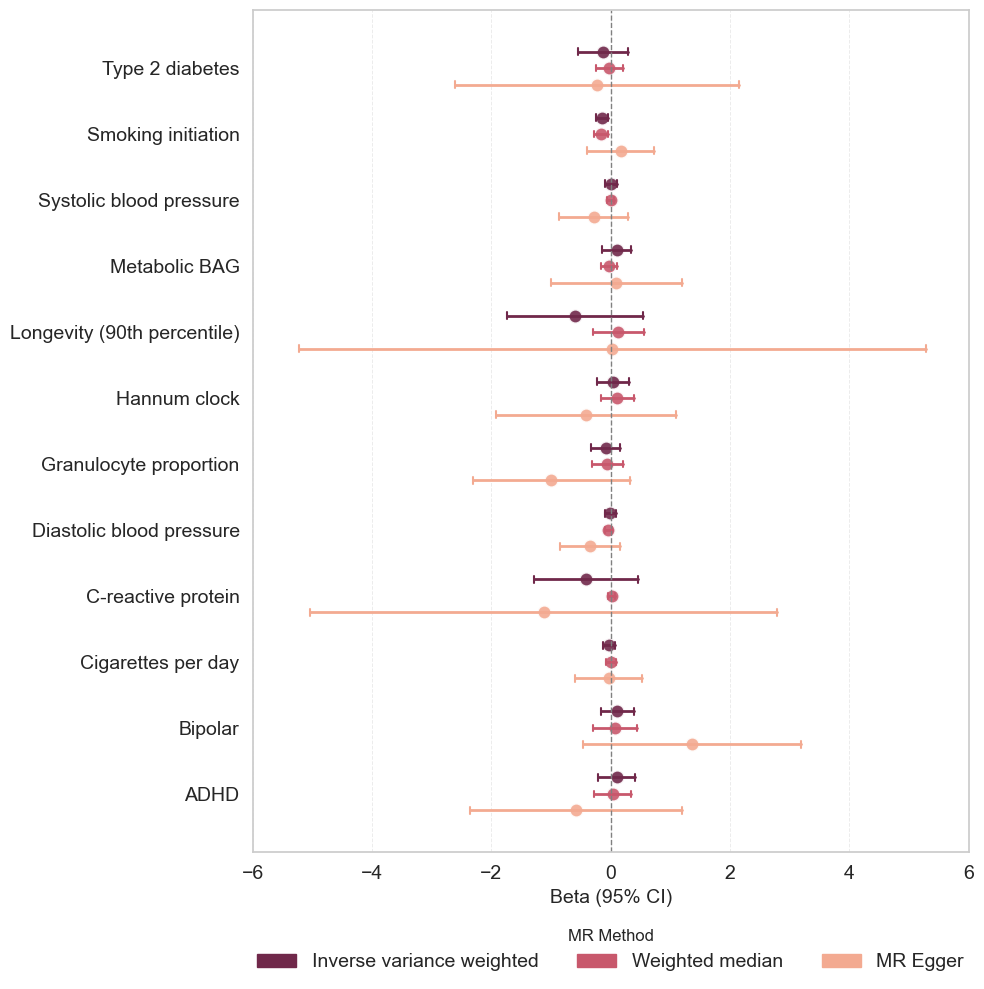

In [90]:
#df = pd.read_excel(cwd+"/MR/TwoSampleMR/combined-output/combined-results-reverse_FDR.xlsx")
df = pd.read_excel("/MR/TwoSampleMR/reverse-MR-BAG-updated.xlsx")

# ==== convert columns ====
for col in ['b', 'se', 'pval']:
    df[col] = df[col].astype(str).str.replace(',', '.', regex=False).astype(float)

df['ci_lower'] = df['b'] - 1.96 * df['se']
df['ci_upper'] = df['b'] + 1.96 * df['se']
#df['outcome'] = df['outcome'].str.capitalize()

# ==== plot settings ====
exposures = df['outcome'].unique()[::-1]

methods = ['Inverse variance weighted', 'Weighted median', 'MR Egger']
method_colors = {
    'Inverse variance weighted': cmap_cat[9],  
    'Weighted median': cmap_cat[6],            
    'MR Egger': cmap_cat[2]   
}

exposure_positions = {exposure: i for i, exposure in enumerate(exposures)}
method_offset = {'Inverse variance weighted': -0.25,
                 'Weighted median': 0,
                 'MR Egger': 0.25}
df['y'] = df.apply(lambda row: exposure_positions[row['outcome']] + method_offset[row['method']], axis=1)

# ==== clip settings ====
x_min, x_max = -6, 6
clip_buffer = 0.1 # 0.8
x_min_buffered = x_min + clip_buffer
x_max_buffered = x_max - clip_buffer
arrow_gap = 0.3
cap_length = 0.05

## Calculate range based on CI values
#x_min = df['ci_lower'].min()
#x_max = df['ci_upper'].max()

# Add a small buffer
#buffer = 0.5
#x_min -= buffer
#x_max += buffer


# ==== plot ====
plt.figure(figsize=(10, 10))

for _, row in df.iterrows():
   # if row['b'] < x_min or row['b'] > x_max:
   #     continue

    y = row['y']
    color = method_colors.get(row['method'], '#aaaaaa')

    # CI values
    ci_lower, ci_upper = row['ci_lower'], row['ci_upper']
    clipped_lower = max(ci_lower, x_min_buffered)
    clipped_upper = min(ci_upper, x_max_buffered)

    is_clipped_left = ci_lower < x_min_buffered
    is_clipped_right = ci_upper > x_max_buffered

    ci_line_start = clipped_lower + arrow_gap if is_clipped_left else clipped_lower
    ci_line_end = clipped_upper - arrow_gap if is_clipped_right else clipped_upper

    # plot estimate
    plt.plot(row['b'], y, 'o', color=color,
             markersize=10, markeredgewidth=1.5, markeredgecolor='white', alpha=0.9)

    # plot CI line
    plt.plot([ci_line_start, ci_line_end], [y, y], color=color, linewidth=2)

    # caps and arrows
    if not is_clipped_left:
        plt.plot([clipped_lower, clipped_lower], [y - cap_length, y + cap_length], color=color, linewidth=1.5)
    else:
        plt.annotate('', xy=(x_min_buffered, y), xytext=(x_min_buffered + 0.015, y),
                     arrowprops=dict(arrowstyle='-|>', color=color, lw=2))

    if not is_clipped_right:
        plt.plot([clipped_upper, clipped_upper], [y - cap_length, y + cap_length], color=color, linewidth=1.5)
    else:
        plt.annotate('', xy=(x_max_buffered, y), xytext=(x_max_buffered - 0.015, y),
                     arrowprops=dict(arrowstyle='-|>', color=color, lw=2))
        
        # annotate with * if FDR significant
#    if row.get('significant_fdr', False):
 #       plt.text(row['b'] + 0.5, y + 0.08, '*', fontsize=fontsize_ticks + 2,
  #               va='bottom', ha='center', color='black', fontweight='bold')



# axis and styling
plt.axvline(0, color='gray', linestyle='--', linewidth=1)

plt.yticks(ticks=range(len(exposures)), labels=exposures, fontsize=fontsize_ticks)
plt.xticks(fontsize=fontsize_ticks)

plt.xlim(x_min, x_max)
plt.xlabel("Beta (95% CI)", fontsize=fontsize_labels)
#plt.title("MR Estimates of brain age factor on traits (95% CI)", fontsize=fontsize_title, weight='bold')

# manual legend
handles = [
    mpatches.Patch(color=cmap_cat[9], label='Inverse variance weighted'),
    mpatches.Patch(color=cmap_cat[6], label='Weighted median'),
    mpatches.Patch(color=cmap_cat[2], label='MR Egger'),
]

plt.legend(handles=handles, title="MR Method", fontsize=fontsize_ticks, frameon=False, loc='lower right')

plt.gca().invert_yaxis()
#plt.gca().set_facecolor('#f9f9f9')

plt.grid(axis='x', linestyle='--', color='gray', alpha=0.15, linewidth=0.7)
plt.grid(axis='y', visible=False)

plt.legend(handles=handles, title="MR Method", fontsize=fontsize_ticks, frameon=False,
           loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=3)



plt.tight_layout()

# Save
plt.savefig("MR/mr_estimates_reverse.png", dpi=300, bbox_inches='tight')
plt.show()


## Panel MR figure

EW 20251210: next block likely outdated but useful for plotting settings

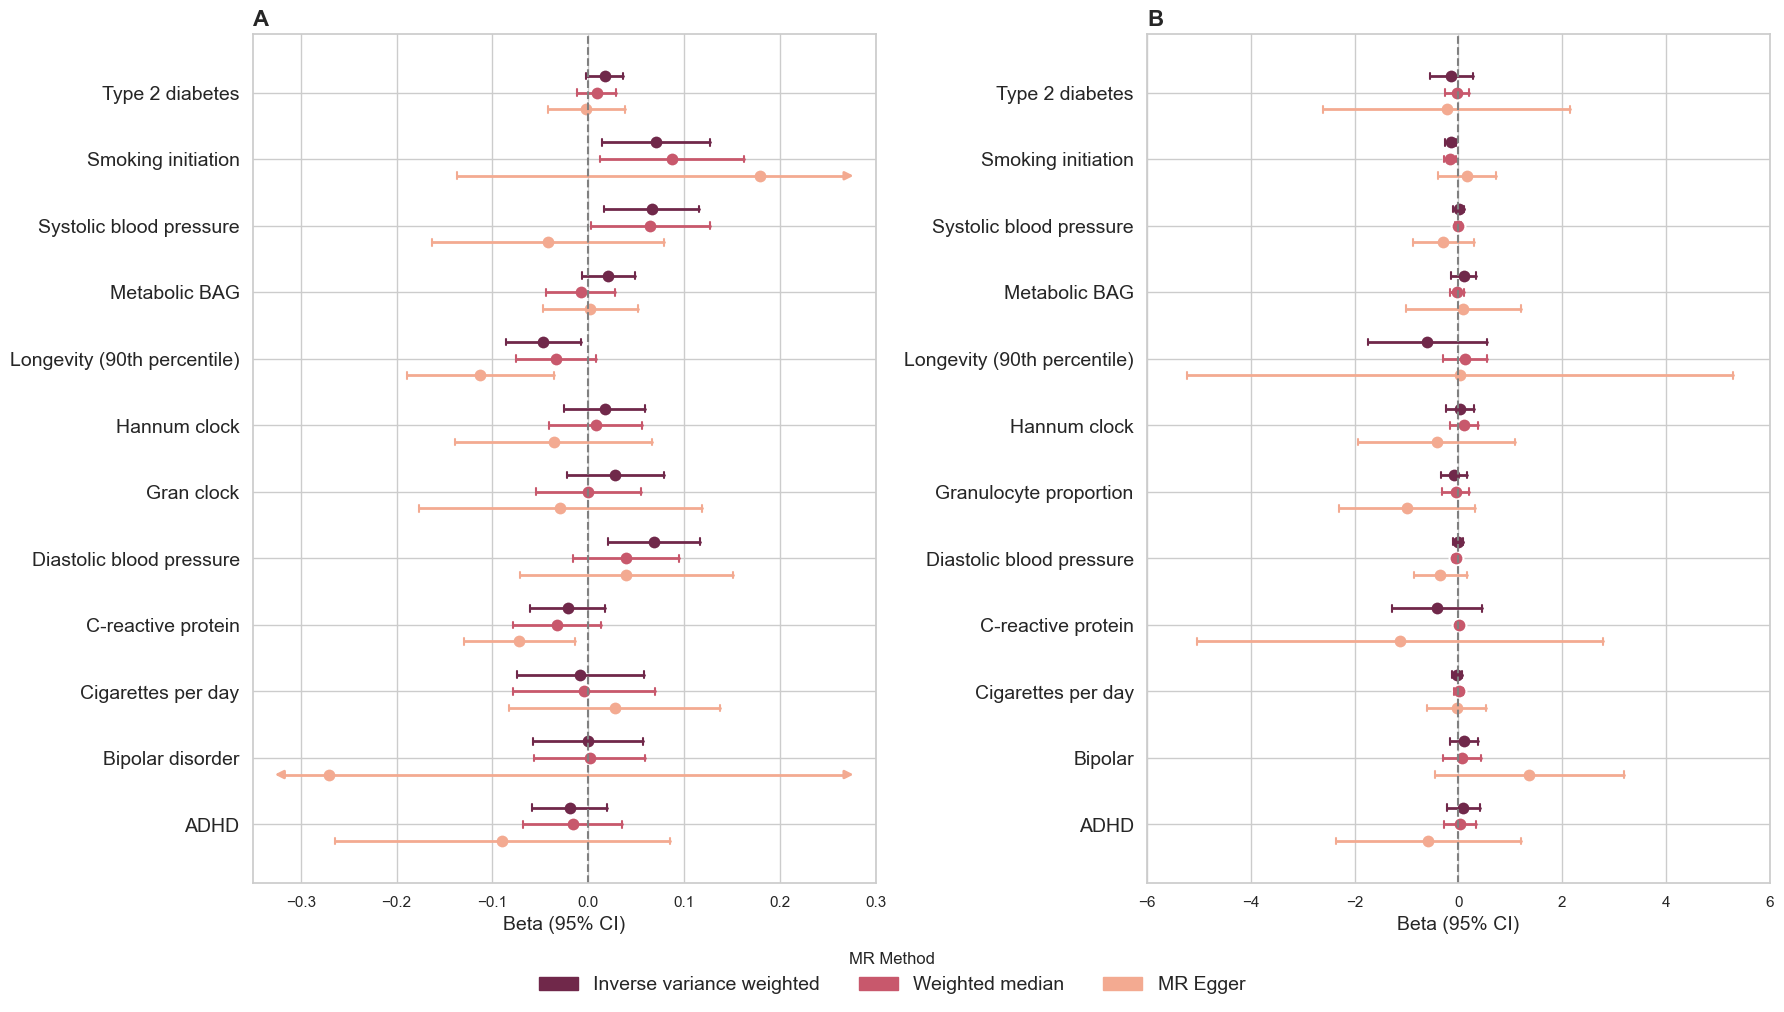

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# === Define Color Palette ===
#cmap_cat = sns.color_palette("tab10")
#
##method_colors = {
 #   'Inverse variance weighted': cmap_cat[9],
 #   'Weighted median': cmap_cat[6],
 #   'MR Egger': cmap_cat[2]
#}

#legend_handles = [
 #   mpatches.Patch(color=cmap_cat[9], label='Inverse variance weighted'),
 #   mpatches.Patch(color=cmap_cat[6], label='Weighted median'),
 #   mpatches.Patch(color=cmap_cat[2], label='MR Egger'),
#]

fontsize_ticks = 14
fontsize_labels = 14
cap_length = 0.05

import matplotlib.patches as mpatches

# === Define your 10 categorical colors (your custom palette) ===
colors_hex_cat = [
    '#fbe6c5', '#f7c9a7', '#f3aa91', '#ee8a82', '#e2797a',
    '#d56973', '#c8586c', '#ab4762', '#8d3757', '#70284a'
]
cmap_cat = colors_hex_cat

# Assign MR method colors based on your preferred hex codes
method_colors = {
    'Inverse variance weighted': cmap_cat[9],  # light blue
    'Weighted median': cmap_cat[6],            # pink
    'MR Egger': cmap_cat[2]                    # green
}

# Legend using same colors
legend_handles = [
    mpatches.Patch(color=cmap_cat[9], label='Inverse variance weighted'),
    mpatches.Patch(color=cmap_cat[6], label='Weighted median'),
    mpatches.Patch(color=cmap_cat[2], label='MR Egger'),
]


# === Load Panel A Data (Forward MR) ===
df_a = pd.read_excel("/MR/TwoSampleMR/forward-MR-BAG-updated.xlsx")
for col in ['b', 'se', 'pval']:
    df_a[col] = df_a[col].astype(str).str.replace(',', '.', regex=False).astype(float)
df_a['ci_lower'] = df_a['b'] - 1.96 * df_a['se']
df_a['ci_upper'] = df_a['b'] + 1.96 * df_a['se']
df_a['outcome'] = df_a['outcome'].str.capitalize()
exposures_a = df_a['exposure'].unique()[::-1]
exposure_positions_a = {exposure: i for i, exposure in enumerate(exposures_a)}
method_offset = {'Inverse variance weighted': -0.25, 'Weighted median': 0, 'MR Egger': 0.25}
df_a['y'] = df_a.apply(lambda row: exposure_positions_a[row['exposure']] + method_offset[row['method']], axis=1)

# === Load Panel B Data (Reverse MR) ===
df_b = pd.read_excel("/MR/TwoSampleMR/reverse-MR-BAG-updated.xlsx")
for col in ['b', 'se', 'pval']:
    df_b[col] = df_b[col].astype(str).str.replace(',', '.', regex=False).astype(float)
df_b['ci_lower'] = df_b['b'] - 1.96 * df_b['se']
df_b['ci_upper'] = df_b['b'] + 1.96 * df_b['se']
exposures_b = df_b['outcome'].unique()[::-1]
exposure_positions_b = {exposure: i for i, exposure in enumerate(exposures_b)}
df_b['y'] = df_b.apply(lambda row: exposure_positions_b[row['outcome']] + method_offset[row['method']], axis=1)

# === Create Subplots for Panel A and B ===
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10), sharex=False)

# ========== Panel A Plot ==========
x_min_a, x_max_a = -0.35, 0.30
clip_buffer_a = 0.02
x_min_buf_a = x_min_a + clip_buffer_a
x_max_buf_a = x_max_a - clip_buffer_a
arrow_gap_a = 0.01

for _, row in df_a.iterrows():
    y = row['y']
    color = method_colors.get(row['method'], '#aaaaaa')
    ci_l, ci_u = row['ci_lower'], row['ci_upper']
    clipped_l = max(ci_l, x_min_buf_a)
    clipped_u = min(ci_u, x_max_buf_a)
    is_clip_l = ci_l < x_min_buf_a
    is_clip_r = ci_u > x_max_buf_a
    ci_start = clipped_l + arrow_gap_a if is_clip_l else clipped_l
    ci_end = clipped_u - arrow_gap_a if is_clip_r else clipped_u

    ax1.plot(row['b'], y, 'o', color=color, markersize=10, markeredgewidth=1.5, markeredgecolor='white')
    ax1.plot([ci_start, ci_end], [y, y], color=color, linewidth=2)
    if not is_clip_l:
        ax1.plot([clipped_l, clipped_l], [y - cap_length, y + cap_length], color=color, linewidth=1.5)
    else:
        ax1.annotate('', xy=(x_min_buf_a, y), xytext=(x_min_buf_a + 0.015, y),
                     arrowprops=dict(arrowstyle='-|>', color=color, lw=2))
    if not is_clip_r:
        ax1.plot([clipped_u, clipped_u], [y - cap_length, y + cap_length], color=color, linewidth=1.5)
    else:
        ax1.annotate('', xy=(x_max_buf_a, y), xytext=(x_max_buf_a - 0.015, y),
                     arrowprops=dict(arrowstyle='-|>', color=color, lw=2))

ax1.axvline(0, color='gray', linestyle='--')
ax1.set_yticks(range(len(exposures_a)))
ax1.set_yticklabels(exposures_a, fontsize=fontsize_ticks)
ax1.set_xlim(x_min_a, x_max_a)
ax1.set_xlabel("Beta (95% CI)", fontsize=fontsize_labels)
ax1.set_title("A", loc='left', fontsize=16, weight='bold')
#ax1.grid(axis='x', linestyle='--', color='gray', alpha=0.15)
ax1.invert_yaxis()

# ========== Panel B Plot ==========
x_min_b, x_max_b = -6, 6
clip_buffer_b = 0.1
x_min_buf_b = x_min_b + clip_buffer_b
x_max_buf_b = x_max_b - clip_buffer_b
arrow_gap_b = 0.3

for _, row in df_b.iterrows():
    y = row['y']
    color = method_colors.get(row['method'], '#aaaaaa')
    ci_l, ci_u = row['ci_lower'], row['ci_upper']
    clipped_l = max(ci_l, x_min_buf_b)
    clipped_u = min(ci_u, x_max_buf_b)
    is_clip_l = ci_l < x_min_buf_b
    is_clip_r = ci_u > x_max_buf_b
    ci_start = clipped_l + arrow_gap_b if is_clip_l else clipped_l
    ci_end = clipped_u - arrow_gap_b if is_clip_r else clipped_u

    ax2.plot(row['b'], y, 'o', color=color, markersize=10, markeredgewidth=1.5, markeredgecolor='white')
    ax2.plot([ci_start, ci_end], [y, y], color=color, linewidth=2)
    if not is_clip_l:
        ax2.plot([clipped_l, clipped_l], [y - cap_length, y + cap_length], color=color, linewidth=1.5)
    else:
        ax2.annotate('', xy=(x_min_buf_b, y), xytext=(x_min_buf_b + 0.015, y),
                     arrowprops=dict(arrowstyle='-|>', color=color, lw=2))
    if not is_clip_r:
        ax2.plot([clipped_u, clipped_u], [y - cap_length, y + cap_length], color=color, linewidth=1.5)
    else:
        ax2.annotate('', xy=(x_max_buf_b, y), xytext=(x_max_buf_b - 0.015, y),
                     arrowprops=dict(arrowstyle='-|>', color=color, lw=2))

ax2.axvline(0, color='gray', linestyle='--')
ax2.set_yticks(range(len(exposures_b)))
ax2.set_yticklabels(exposures_b, fontsize=fontsize_ticks)
ax2.set_xlim(x_min_b, x_max_b)
ax2.set_xlabel("Beta (95% CI)", fontsize=fontsize_labels)
ax2.set_title("B", loc='left', fontsize=16, weight='bold')
#ax2.grid(axis='x', linestyle='--', color='gray', alpha=0.15)
ax2.invert_yaxis()
ax2.grid(axis='y', visible=False)


# === Shared Legend Below Panels ===
fig.legend(handles=legend_handles, title="MR Method", fontsize=fontsize_ticks,
           loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0.04, 1, 1])  # leave space for legend
plt.savefig("MR/mr_panels_A_B.png", dpi=300, bbox_inches='tight')
plt.show()


## GenR PGS - BAG

(EW 20251210: Vilte's code; I.e. figure 3A)

In [4]:
os.chdir('X:\\Psychology\\ResearchProjects\\EWalton\\BrainHealth\\BrainAge_GWAS\\output\\all_plots\\forPlotting_Shir_final')
cwd = os.getcwd()
print(cwd)


X:\Psychology\ResearchProjects\EWalton\BrainHealth\BrainAge_GWAS\output\all_plots\forPlotting_Shir_final


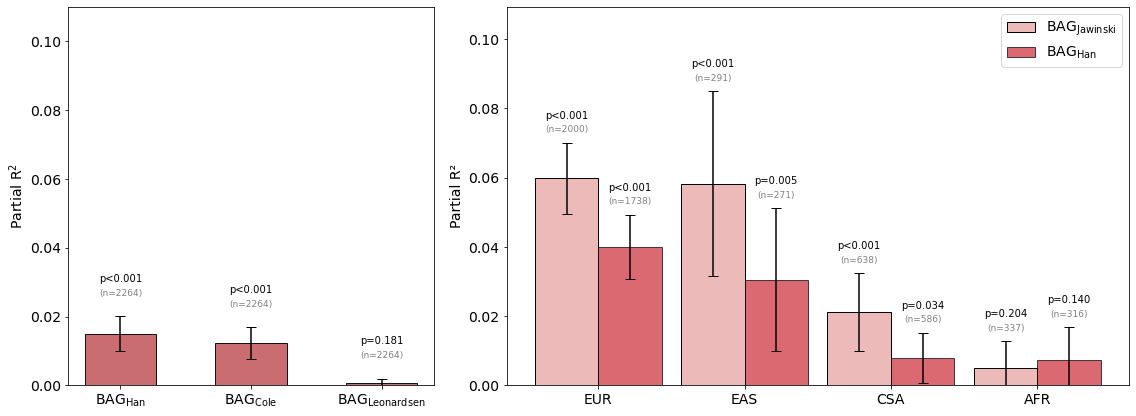

In [95]:


# =====================================================
# GenR data (panel A)
# =====================================================
df2 = pd.read_csv(cwd + "/trio/SM_table_renamed_20251209.csv", delimiter='\t')



# keep only BAG results for child-unadjusted
# remove genetic transmission results
# remove child and parents adjusted effects
mask = (
    df2["Term"].str.contains("unadjusted", case=False, na=False) &
    df2["model"].str.contains("BAG", case=False, na=False)
)

df2 = df2[mask]


def se_r2(R2, n):
    """Compute SE of R²."""
    return np.sqrt((4 * R2 * (1 - R2)**2) / (n - 2))

df2['se_r2'] = se_r2(df2['partial.r2'], df2['n'])

genr = df2.sort_values("partial.r2", ascending=False).reset_index(drop=True)



label_map = {
    "BAGHan": r"BAG$_{\mathrm{Han}}$",
    "BAGLeonardsen": r"BAG$_{\mathrm{Leonardsen}}$",
    "BAGCole": r"BAG$_{\mathrm{Cole}}$"
}
genr["label"] = genr["model"].map(label_map)

# =====================================================
# UKBB Data (panel B)
# =====================================================
df = pd.read_excel(cwd + "/trio/UKBB_validation_subset.xlsx")

def se_r2(R2, n):
    """Compute SE of R²."""
    return np.sqrt((4 * R2 * (1 - R2)**2) / (n - 2))

df['SE_Han'] = se_r2(df['R2_Han'], df['n_Han'])
df['SE_Jaw'] = se_r2(df['R2_Jawinski'], df['n_Jawinski'])
df = df.sort_values("Ancestry", ascending=False).reset_index(drop=True)

# =====================================================
# Plotting
# =====================================================
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(
    1, 2, figsize=(16, 6),
    gridspec_kw={'width_ratios': [1, 1.7]}  # panel A = 1x, panel B = 1.7x seemed to work best
)

# ---------------- Panel A: GenR (reminder: plot here R2 eventually!) ----------------
panel_a_width = 0.55
ax[0].bar(genr["label"], genr["partial.r2"], width=panel_a_width,
          color="#C55D60", edgecolor="black", alpha=0.9,
          yerr=genr["se_r2"], capsize=5)
ax[0].set_ylabel(r"Partial R$^2$")

# use when differnt scale to UKBB
#ax[0].set_ylim(0, max(genr["partial.r2"] + genr["se_r2"]) * 1.1)

# use when same scale as UKBB
ax[0].set_ylim(0, 0.11)


# annotate GenR bars v2
for i, row in genr.iterrows():
    p_label = "p<0.001" if row["Pr(>|t|)"] < 0.001 else f"p={row['Pr(>|t|)']:.3f}"
    
    # use when different scale to UKBB
    #ax[0].text(i,
    #           row["partial.r2"] + row["se_r2"] + 0.001,
    #           p_label, ha="center", fontsize=10)
    #ax[0].text(i,
    #           row["partial.r2"] + row["se_r2"] + 0.0003,
    #           f"(n={row['n']})", ha="center", fontsize=9, color="grey")
    
    # use when same scale as UKBB
    ax[0].text(i,
               row["partial.r2"] + row["se_r2"] + 0.01,
               p_label, ha="center", fontsize=10)
    ax[0].text(i,
               row["partial.r2"] + row["se_r2"] + 0.006,
               f"(n={row['n']})", ha="center", fontsize=9, color="grey")
    

# ---------------- Panel B: UKBB ----------------
labels = df["Ancestry"]
n = len(labels)
bar_width = 1.3
group_positions = np.arange(n) * 3  # spacing

# Bars
ax[1].bar(group_positions - bar_width/2, df["R2_Jawinski"], width=bar_width,
          color="#EBBAB9", edgecolor="black", yerr=df["SE_Jaw"], capsize=5,
          label=r"BAG$_{\mathrm{Jawinski}}$")
ax[1].bar(group_positions + bar_width/2, df["R2_Han"], width=bar_width,
          color="#CC2936", edgecolor="black", alpha=0.7,
          yerr=df["SE_Han"], capsize=5,
          label=r"BAG$_{\mathrm{Han}}$")

# y-axis limit
ymax = max(
    (df["R2_Han"] + df["SE_Han"]).max(),
    (df["R2_Jawinski"] + df["SE_Jaw"]).max()
) + 0.01
ax[1].set_ylim(0, ymax * 1.15)

# annotating bars
for i, row in df.iterrows():
    # Jawinski
    p_label_jaw = "p<0.001" if row["p_Jawinski"] < 0.001 else f"p={row['p_Jawinski']:.3f}"
    ax[1].text(group_positions[i] - bar_width/2,
               row["R2_Jawinski"] + row["SE_Jaw"] + 0.007,
               p_label_jaw, ha="center", fontsize=10)
    ax[1].text(group_positions[i] - bar_width/2,
               row["R2_Jawinski"] + row["SE_Jaw"] + 0.003,
               f"(n={row['n_Jawinski']})", ha="center", fontsize=9, color="grey")

    # Han
    p_label_han = "p<0.001" if row["p_Han"] < 0.001 else f"p={row['p_Han']:.3f}"
    ax[1].text(group_positions[i] + bar_width/2,
               row["R2_Han"] + row["SE_Han"] + 0.007,
               p_label_han, ha="center", fontsize=10)
    ax[1].text(group_positions[i] + bar_width/2,
               row["R2_Han"] + row["SE_Han"] + 0.003,
               f"(n={row['n_Han']})", ha="center", fontsize=9, color="grey")

# X-axis formatting
ax[1].set_xticks(group_positions)
ax[1].set_xticklabels(labels)
ax[1].set_ylabel("Partial R²")
ax[1].legend()

plt.tight_layout()
plt.savefig(cwd + "/trio/validation_UKBB_GenR_panels_notoverlapping_20251210.png", dpi=600)
plt.show()


## GenR PGS - health traits

(EW new 20251124:
new figure - only child to health, unadjusted for parents)

                         model                       Term  Estimate  \
0        BAG$_{\mathrm{Cole}}$  child (parent-unadjusted)  0.113771   
1         BAG$_{\mathrm{Han}}$  child (parent-unadjusted)  0.118714   
2  BAG$_{\mathrm{Leonardsen}}$  child (parent-unadjusted)  0.028213   
3                    Attention  child (parent-unadjusted)  0.037163   
4                Internalizing  child (parent-unadjusted)  0.042867   

   Std. Error      Pr(>|t|)       rho  partial.r2     n  
0    0.021514  1.350000e-07  0.110667    0.012247  2264  
1    0.020161  4.480000e-09  0.122503    0.015007  2264  
2    0.021100  1.813102e-01  0.028166    0.000793  2264  
3    0.024101  1.232567e-01  0.036067    0.001301  1831  
4    0.024026  7.455549e-02  0.041570    0.001728  1831  
                model         Term  Estimate  Std. Error  Pr(>|t|)       rho  \
3           Attention  effect size  0.037163    0.024101  0.123257  0.036067   
4       Internalizing  effect size  0.042867    0.024026  0.07455

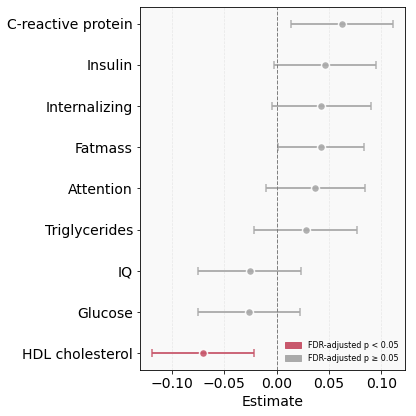

In [98]:
df2 = pd.read_csv(cwd + "/trio/SM_table_renamed_20251209.csv", delimiter='\t')

fontsize_title = 10
fontsize_ticks = 10


def add_subscript(label, subscript_part):
    return f"BAG$_{{\\mathrm{{{subscript_part}}}}}$"

# Apply only to rows in the "model" column
df2["model"] = df2["model"].apply(
    lambda x: add_subscript("BAG", str(x)[3:]) if str(x).startswith("BAG") else str(x)
)

print(df2.head())

################ EW 20251124
# rename:
replacements = {
    'child (parent-unadjusted)': 'effect size'
}

df2['Term'] = df2['Term'].replace(replacements)


# remove BAG results
# remove genetic transmission results
# remove child and parents adjusted effects
unwanted = ['child', 'mother','father', 'BAG']

mask = df2['Term'].str.contains('|'.join(unwanted), case=False, na=False) | \
       df2['model'].str.contains('|'.join(unwanted), case=False, na=False)

df2 = df2[~mask]


from statsmodels.stats.multitest import multipletests


is_brain_age = df2['model'].str.contains('BAG', case=False, na=False)
pvals_group1 = df2.loc[~is_brain_age, "Pr(>|t|)"]


# Perform FDR correction 
reject1, pvals_corrected1, _, _ = multipletests(pvals_group1, alpha=0.05, method='fdr_bh')

# Create a new column with NaNs initially
df2['Pvalue.corrected'] = np.nan

# Fill adjusted p-values back
df2.loc[~is_brain_age, 'Pvalue.corrected'] = pvals_corrected1

print(df2.head())

# ---- SETTINGS ----
sig_color = cmap_cat[6]
nonsig_color = '#aaaaaa'

fontsize_ticks = 14
fontsize_labels = 12
fontsize_title = 14

# ---- SORT ROWS BY EFFECT SIZE ----
# Sort by Estimate from low → high
df2_sorted = df2.sort_values("Estimate").reset_index(drop=True)
df2_sorted["y_index"] = range(len(df2_sorted))

# Determine colors
if "Pvalue.corrected" in df2_sorted.columns:
    df2_sorted["color"] = [
        sig_color if p <= 0.05 else nonsig_color
        for p in df2_sorted["Pvalue.corrected"]
    ]
else:
    df2_sorted["color"] = "black"

# Prepare figure
fig, ax = plt.subplots(figsize=(6, 6))

# ---- Plot error bars ----
for _, row in df2_sorted.iterrows():
    est = row["Estimate"]
    se = row["Std. Error"]
    ci95 = 1.96 * se
    yi = row["y_index"]
    c = row["color"]

    ax.errorbar(
        x=est,
        y=yi,
        xerr=ci95,
        fmt='o',
        color=c,
        ecolor=c,
        elinewidth=2,
        capsize=4,
        markersize=8,
        markeredgewidth=1.5,
        markeredgecolor='white',
        alpha=0.9
    )

# ---- Add zero line ----
ax.axvline(0, linestyle='--', color='gray', linewidth=1)

# ---- Left y-axis labels: MODEL names ----
ax.set_yticks(df2_sorted["y_index"])
ax.set_yticklabels(df2_sorted["model"], fontsize=fontsize_ticks)

# ---- Remove right y-axis entirely ----
ax2 = ax.twinx()
ax2.set_yticks([])
ax2.set_ylabel("")
ax2.set_yticklabels([])

# ---- Style / labels ----
ax.set_xlabel("Estimate", fontsize=fontsize_title)
ax.tick_params(axis='x', labelsize=14)
#ax.set_ylabel("Model", fontsize=fontsize_title)

ax.set_facecolor('#f9f9f9')
ax.grid(axis='x', linestyle='--', color='gray', alpha=0.15, linewidth=0.7)
ax.grid(axis='y', visible=False)

# Frame styling
spine_color = '#cccccc'
for spine in ax.spines.values():
    spine.set_color(spine_color)
    spine.set_linewidth(1)

# ---- Legend ----
sig_patch = mpatches.Patch(color=sig_color, label='FDR-adjusted p < 0.05')
nonsig_patch = mpatches.Patch(color='#aaaaaa', label='FDR-adjusted p ≥ 0.05')

ax.legend(handles=[sig_patch, nonsig_patch],
          fontsize=8,
          frameon=False,
          loc='lower right')

plt.tight_layout()
plt.savefig(cwd + "/trio/PGS.child_health_20251209.png", dpi=300, bbox_inches='tight')
plt.show()

In [7]:
print(df2.head())

  model\tTerm\tEstimate\tStd. Error\tPr(>|t|)\trho\tpartial.r2
0  BAG.Cole\tchild (parent-unadjusted)\t0.1137707...          
1  BAG.Han\tchild (parent-unadjusted)\t0.11871363...          
2  BAG.Leonardsen\tchild (parent-unadjusted)\t0.0...          
3  CBCLatt\tchild (parent-unadjusted)\t0.03716289...          
4  CBCLint\tchild (parent-unadjusted)\t0.04286713...          




## trio plot

(EW new 20251124:
GenR, only child adjusted and mother/father (all from same model) - remove transmission and unadjusted effects
move BAGs to first row)

                         model                       Term  Estimate  \
0        BAG$_{\mathrm{Cole}}$  child (parent-unadjusted)  0.113771   
1         BAG$_{\mathrm{Han}}$  child (parent-unadjusted)  0.118714   
2  BAG$_{\mathrm{Leonardsen}}$  child (parent-unadjusted)  0.028213   
3                    Attention  child (parent-unadjusted)  0.037163   
4                Internalizing  child (parent-unadjusted)  0.042867   

   Std. Error      Pr(>|t|)       rho  partial.r2     n  
0    0.021514  1.350000e-07  0.110667    0.012247  2264  
1    0.020161  4.480000e-09  0.122503    0.015007  2264  
2    0.021100  1.813102e-01  0.028166    0.000793  2264  
3    0.024101  1.232567e-01  0.036067    0.001301  1831  
4    0.024026  7.455549e-02  0.041570    0.001728  1831  


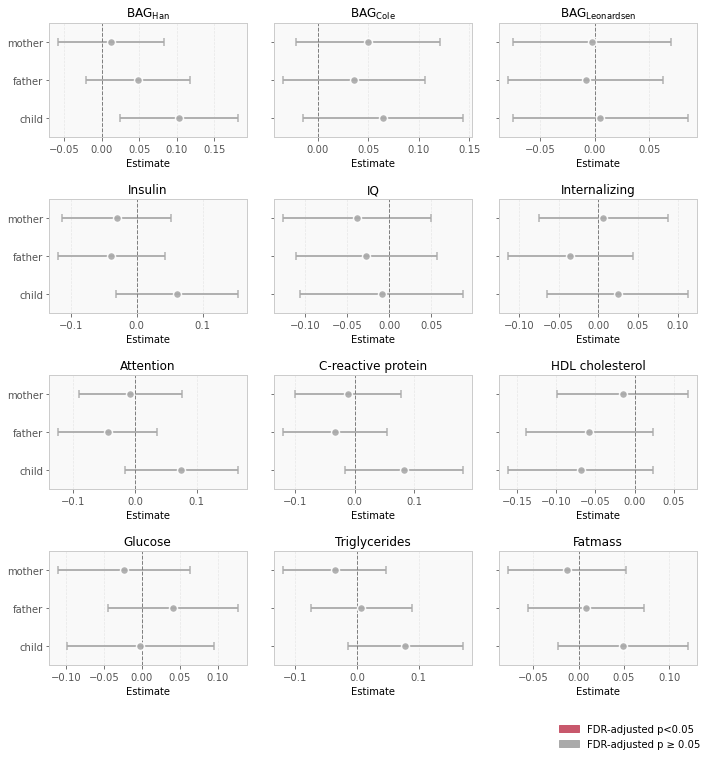

In [100]:
df2 = pd.read_csv(cwd + "/trio/SM_table_renamed_20251209.csv", delimiter='\t')

fontsize_title = 10
fontsize_ticks = 10


def add_subscript(label, subscript_part):
    return f"BAG$_{{\\mathrm{{{subscript_part}}}}}$"

# Apply only to rows in the "model" column
df2["model"] = df2["model"].apply(
    lambda x: add_subscript("BAG", str(x)[3:]) if str(x).startswith("BAG") else str(x)
)

print(df2.head())

################ EW 20251124
# remove BAG results
# remove genetic transmission results
# remove child unadjusted effects
unwanted = ['parent-unadjusted']

mask = df2['Term'].str.contains('|'.join(unwanted), case=False, na=False) 

df2 = df2[~mask]


from statsmodels.stats.multitest import multipletests
df2['Pvalue.corrected'] = multipletests(df2['Pr(>|t|)'], method='fdr_bh')[1]


df2 = df2.sort_values(by='model', key=lambda x: x.str.contains('BAG', case=False, na=False), ascending=False)


g = sns.FacetGrid(
    df2,
    col="model",
    col_wrap=3,
    sharex=False,
    sharey=True,
    height=3,
    aspect=1.2
)

g.fig.set_size_inches(10, 10)  # width=14 inches, height=6 inches

def plot_estimates(data, color, **kwargs):
    ax = plt.gca()
    data = data.sort_values("Term")
    y_pos = np.arange(len(data))

    sig_color = cmap_cat[6]
    nonsig_color = '#aaaaaa'

    if "Pvalue.corrected" in data.columns:
        colors = [sig_color if val <= 0.05 else nonsig_color for val in data["Pvalue.corrected"]]
    else:
        colors = ['black'] * len(data)

    for i, (est, se, c) in enumerate(zip(data["Estimate"], data["Std. Error"], colors)):
        ci95 = 1.96 * se
        ax.errorbar(
            x=est,
            y=i,
            xerr=ci95,
            fmt='o',
            color=c,
            ecolor=c,
            elinewidth=2,
            capsize=4,
            markersize=8,
            markeredgewidth=1.5,
            markeredgecolor='white',
            alpha=0.9
        )

    ax.axvline(0, linestyle='--', color='gray', linewidth=1)
    ax.set_yticks(y_pos)

    padding = 0.5
    ax.set_ylim(-padding, len(data) - 1 + padding)

    ax.set_yticklabels(data["Term"].to_numpy(dtype=str), fontsize=fontsize_ticks)  # use fontsize_ticks here
    ax.tick_params(axis='y', pad=2, labelsize=fontsize_ticks)  # ensure y tick labels font size
    ax.tick_params(axis='x', labelsize=fontsize_ticks)         # use fontsize_ticks for x tick labels

    # Styling for frame and ticks
    ax.set_facecolor('#f9f9f9')
    ax.grid(axis='x', linestyle='--', color='gray', alpha=0.15, linewidth=0.7)
    ax.grid(axis='y', visible=False)

    spine_color = '#cccccc'  # light gray frame color
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color(spine_color)
        spine.set_linewidth(1)

    tick_color = '#555555'  # medium gray tick color
    ax.tick_params(axis='x', colors=tick_color)
    ax.tick_params(axis='y', colors=tick_color)

g.map_dataframe(plot_estimates)

# Set axis labels with fontsize_labels (need to set manually on each axis)
for ax in g.axes.flat:
    ax.set_xlabel("Estimate", fontsize=fontsize_title)
    ax.set_ylabel("", fontsize=fontsize_title)  # empty y-label but fontsize applied

#g.set_titles(col_template="{col_name}", size=fontsize_title)  # use fontsize_title here
g.set_titles(col_template="{col_name}", size=fontsize_labels)  # use fontsize_title here

sig_patch = mpatches.Patch(color=cmap_cat[6], label='FDR-adjusted p<0.05')
nonsig_patch = mpatches.Patch(color='#aaaaaa', label='FDR-adjusted p ≥ 0.05')

g.fig.legend(
    handles=[sig_patch, nonsig_patch],
    fontsize=fontsize_ticks,  # legend font size matches ticks
    frameon=False,
    loc='upper right',
    bbox_to_anchor=(1, -0.001),
    borderaxespad=0.8
)

plt.tight_layout()
plt.savefig(cwd + "/trio/trio_20251209.png", dpi=300, bbox_inches='tight')
plt.show()
